A brief tutorial on using the flowequations package.
<!-- Contents -->

In [1]:
# Recommended settings to consider
import jax, os
jax.config.update('jax_platform_name', 'cpu')       # or 'gpu' (preferred for L > 14)
jax.config.update("jax_enable_x64", True)           # Allows for double precision
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.75'  # How much memory to be preallocated

First we show how to calculate the flowed Hamiltonian by generating a default Hamiltonian and using the `ODEs` to obtain the (near-) energy diagonal Hamiltonian at $l \to \infty$.

In [2]:
from flowequations import ODEs, models
import numpy as np
# Define system parameters:
L = 8       # Number of sites
W = 1.      # Disorder strength
J = 1.      # Hopping strength
Delta = 1.  # Interaction strength
R = 5       # Number of disorder realizations

# flow equation parameters:
method = 'normal'
# Avaliable options of the method (see documentation or my thesis for more info).
# ↳ tensor:     Default vacuum ordering implementation
# ↳ vacform:    Optimized vacuum ordering implementation
# ↳ normal:     Normal-ordering with respect to the density matrix \rho which sets the average particle number density n. (this option requires passing n in the flow equation!)
n = 0.5


H2 = models.tight_binding_model(L,W,J,R = R)         # shape (R,L,L) or (L,L) if R=1
H4 = models.nearest_neighbour_interactions(L,Delta)  # shape (L,L,L,L)

H2_flowed = np.zeros((R,L,L))
H4_flowed = np.zeros((R,L,L,L,L))

for i in range(R):
    H2_flowed[i], H4_flowed[i] = ODEs.flow_equation(H2[i], H4, method = method, n = n)



Great! We have obtained the flowed Hamiltonians. Now we would like to establish the loss of unitarity. This can be done with the `trace` library.

In [3]:
from flowequations.trace import relative_difference_second_trace

RDs = np.zeros(R) # Relative differences
for i in range(R):
    RDs[i] = relative_difference_second_trace(H2[i], H4, H2_flowed[i], H4_flowed[i], n)

print('Average relative diffence for the second trace invariant:', np.average(RDs))

Average relative diffence for the second trace invariant: 2.1733770078889602e-08


As shown in my thesis, the second trace is expected to remain invariant always when the second trace invariant is taken with respect to the same density matrix as used for normal-ordering on the Hamiltonian. To confirm this, we simply change the `n` parameter for `relative_trace_invariant_difference`.

In [4]:
RDs_quarter_density = np.zeros(R) # Relative difference where the trace is taken with respect to the vacuum
for i in range(R):
    RDs_quarter_density[i] = relative_difference_second_trace(H2[i], H4, H2_flowed[i], H4_flowed[i], 0.25) # 0. since the trace is taken with respect to the vacuum

print('Average relative difference for the second trace invariant for a different density matrix:', np.average(RDs_quarter_density))

Average relative difference for the second trace invariant for a different density matrix: 0.08870771058500326


The relative difference of the second trace invariant alone is not a particularly useful measurement when we want to quantify the loss of unitarity due to the truncation scheme. Since the trace is taken over the entire Hilbert space, we are able to obtain the trace polynomial in terms of powers of `n`. We can then use this trace polynomial to obtain the second trace invariant within a subspace of the Hilbert space. For more information, refer to section 2.4 of my thesis. We are able to calculate the second trace invarariant within a subspace using the `trace` library.

In [5]:
from flowequations.trace import second_trace_invariant_coefficients, relative_difference_second_trace_per_sector

coef_start =  np.zeros((R,4))
coef_end_HF = np.zeros((R, 4)) # HF for half-filling normal-ordering
for i in range(R):
    coef_start[i] = second_trace_invariant_coefficients(H2[i], H4)
    coef_end_HF[i] = second_trace_invariant_coefficients(H2_flowed[i], H4_flowed[i])

RDs_per_sector_HF = np.zeros((R, L+1))
for i in range(R):
    RDs_per_sector_HF[i] = relative_difference_second_trace_per_sector(L, coef_start[i], coef_end_HF[i])

To illustrate the relative difference within a subspace, we use `matplotlib`.

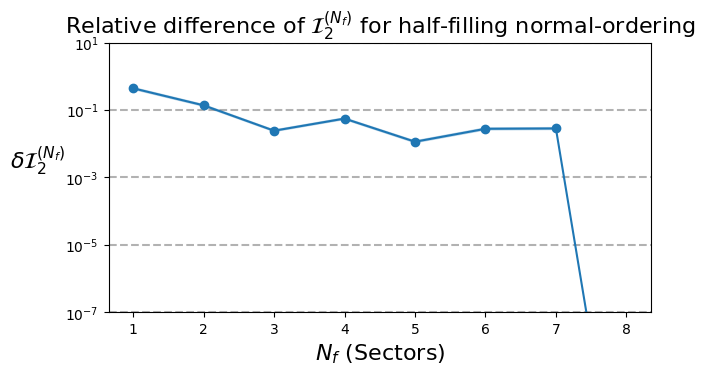

In [6]:
import matplotlib.pyplot as plt

average_RDs_per_sector_HF = np.average(RDs_per_sector_HF, axis = 0)
stderr_RDs_per_sector_HF = np.std(RDs_per_sector_HF, axis = 0)/np.sqrt(R)
sectors = np.arange(1,L+1) # omit the 0 particle sector

fig, axes = plt.subplots()

for i in range(-7, 2, 2):
    plt.axhline(y = 10**i, color = 'black', linestyle = '--', alpha = 0.3)

plt.plot(sectors, average_RDs_per_sector_HF[sectors], 'o-')
plt.fill_between(sectors, average_RDs_per_sector_HF[sectors] - stderr_RDs_per_sector_HF[sectors], average_RDs_per_sector_HF[sectors] + stderr_RDs_per_sector_HF[sectors], alpha = 0.3)

plt.xlabel(r'$N_f$ (Sectors)', fontsize = 16)
plt.ylabel(r'$\delta \mathcal{I}_2^{(N_f)}$', fontsize = 16, rotation = 0, labelpad = 20)
axes.set_yscale('log')
axes.set_ylim(bottom=1.e-7, top = 1.e1)
plt.title(r'Relative difference of $\mathcal{I}^{(N_f)}_2$ for half-filling normal-ordering', fontsize = 16)
fig.set_figheight(3.5)
fig.set_figwidth(7)
plt.show()


Note that the particle sector $N_f = 8$ contains only one combination of $8$ filled particles in a chain of $8$ sites. The benefit of investigating the second trace invariant within a particle sector allows us to compare different choices of normal-ordering. Let us compare with the flow equation using vacuum ordering.

In [7]:
H2_flowed_vac = np.zeros((R,L,L))
H4_flowed_vac = np.zeros((R,L,L,L,L))

for i in range(R):
    H2_flowed_vac[i], H4_flowed_vac[i] = ODEs.flow_equation(H2[i], H4, method = 'vacform')

coef_end_vac = np.zeros((R, 4))
RDs_per_sector_vac = np.zeros((R, L+1))
for i in range(R):
    coef_end_vac[i] = second_trace_invariant_coefficients(H2_flowed_vac[i], H4_flowed_vac[i])
    RDs_per_sector_vac[i] = relative_difference_second_trace_per_sector(L, coef_start[i], coef_end_vac[i])

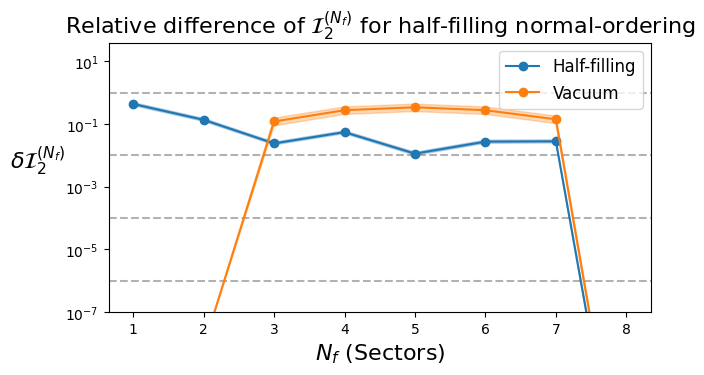

In [11]:
average_RDs_per_sector_vac = np.average(RDs_per_sector_vac, axis = 0)
stderr_RDs_per_sector_vac = np.std(RDs_per_sector_vac, axis = 0)/np.sqrt(R)

fig, axes = plt.subplots()

for i in range(-8, 5, 2):
    plt.axhline(y = 10**i, color = 'black', linestyle = '--', alpha = 0.3)

plt.plot(sectors, average_RDs_per_sector_HF[sectors], 'o-', color = 'C0', label = 'Half-filling')
plt.fill_between(sectors, average_RDs_per_sector_HF[sectors] - stderr_RDs_per_sector_HF[sectors], average_RDs_per_sector_HF[sectors] + stderr_RDs_per_sector_HF[sectors], alpha = 0.3, color = 'C0')

plt.plot(sectors, average_RDs_per_sector_vac[sectors], 'o-', color = 'C1', label = 'Vacuum')
plt.fill_between(sectors, average_RDs_per_sector_vac[sectors] - stderr_RDs_per_sector_vac[sectors], average_RDs_per_sector_vac[sectors] + stderr_RDs_per_sector_vac[sectors], alpha = 0.3, color = 'C1')

plt.xlabel(r'$N_f$ (Sectors)', fontsize = 16)
plt.ylabel(r'$\delta \mathcal{I}_2^{(N_f)}$', fontsize = 16, rotation = 0, labelpad = 20)
axes.set_yscale('log')
axes.set_ylim(bottom=1.e-7, top = 4.e1)
plt.title(r'Relative difference of $\mathcal{I}^{(N_f)}_2$ for half-filling normal-ordering', fontsize = 16)
plt.legend(loc= 'upper right', fontsize = 12)
fig.set_figheight(3.5)
fig.set_figwidth(7)
plt.show()

For vacuum ordering, the first two particle sectors are conserved completely. This is intuitive since the truncation scheme only omits terms with $\mathcal{O}(6)$ number operators. For half-filling normal-ordering we assume the chain to be half-filled and therefore the relative difference of the second trace invariant at $N_f$ around $4$ is lower. <!-- Consider larger systems? -->

### TODO: Heisenberg's equations of motion

### TODO: Choice of basis